# 2.0 Creación de Manifest

## Inputs

### Conexión con Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Librerias

In [ ]:
import os
import requests, time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import os, re, glob
from astropy.io import fits
import pandas as pd


### Paths e Inputs

In [ ]:
PROJ_ROOT    = "/content/drive/MyDrive/Proyecto_Integrador"
DATA_DIR     = f"{PROJ_ROOT}/data/images"
MASTER_CSV   = f"{PROJ_ROOT}/data/dataset.csv"
DATASETS_DIR = f"{PROJ_ROOT}/Deteccion/datasets"

# Qué descargar:
# "bars_only"  -> Bars >= 0.50
# "nonbars"    -> Bars <= 0.25
# "both"       -> combina ambos subconjuntos
MODE = "bars_only"

THRESH_NEG = 0.25
THRESH_POS = 0.50

# Bandas a descargar (ópticas de Legacy Survey)
BANDS = ["g", "r", "z"]

# Capa y tamaño de recorte
LAYER = "ls-dr9"     # puedes cambiar a "ls-dr10" si lo prefieres
PIX_SCALE = 0.262    # arcsec/pixel (óptico)
CUTOUT_ARCMIN = 0.5  # lado del recorte en arcmin; ej. 0.5' = 30"
SIZE_PIX = int((CUTOUT_ARCMIN*60.0)/PIX_SCALE)
SIZE_PIX = max(64, min(SIZE_PIX, 2048))  # límite razonable

# Descarga
NUM_WORKERS = 8       # hilos en paralelo
RETRIES_PER_URL = 2
TIMEOUT_SEC = 60
SLEEP_BETWEEN = 0.25  # segundos entre reintentos

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(DATASETS_DIR, exist_ok=True)
print("Descargas a:", DATA_DIR)


Descargas a: /content/drive/MyDrive/Proyecto_Integrador/data/images


## Descarga de Imagenes

### Obtención de Objetos a descargar

In [ ]:

df = pd.read_csv(MASTER_CSV)
assert {"name","objra","objdec","Bars"}.issubset(df.columns), "Faltan columnas en master"

df["image_id"] = df["name"].astype(str)
df["ra"]  = pd.to_numeric(df["objra"], errors="coerce")
df["dec"] = pd.to_numeric(df["objdec"], errors="coerce")
df["Bars"] = pd.to_numeric(df["Bars"], errors="coerce")

df = df.dropna(subset=["image_id","ra","dec","Bars"]).drop_duplicates(subset=["image_id"])

if MODE == "bars_only":
    df_sub = df[df["Bars"] >= THRESH_POS].copy()
elif MODE == "nonbars":
    df_sub = df[df["Bars"] <= THRESH_NEG].copy()
elif MODE == "both":
    df_sub = pd.concat([df[df["Bars"] >= THRESH_POS], df[df["Bars"] <= THRESH_NEG]], ignore_index=True).drop_duplicates(subset=["image_id"])
else:
    raise ValueError("MODE inválido")

print(MODE, "| objetos a descargar:", len(df_sub))
df_sub.head()


bars_only | objetos a descargar: 3343


,name,objra,objdec,Bars,image_id,ra,dec
1,manga-10001-12702,133.685670,57.480250,0.5,manga-10001-12702,133.685670,57.480250
2,manga-10001-12703,136.017160,57.092329,0.5,manga-10001-12703,136.017160,57.092329
6,manga-10001-1902,134.193923,56.786747,1.0,manga-10001-1902,134.193923,56.786747
7,manga-10001-3701,132.465647,57.143728,0.5,manga-10001-3701,132.465647,57.143728
12,manga-10001-6102,132.653992,57.359668,1.0,manga-10001-6102,132.653992,57.359668


### Endpoints y Función de Descarga

In [ ]:


def cutout_urls(ra, dec, band):
    # probamos dos endpoints; usaremos el primero que responda 200 con datos
    u1 = f"https://www.legacysurvey.org/viewer/fits-cutout?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    u2 = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    return [u1, u2]

def download_one(name, ra, dec, band, out_dir=DATA_DIR):
    out_path = os.path.join(out_dir, f"{name}_{band}.fits")
    if os.path.exists(out_path) and os.path.getsize(out_path) > 1000:
        return (name, band, True, out_path, "exists")

    urls = cutout_urls(ra, dec, band)
    for u in urls:
        for _ in range(RETRIES_PER_URL):
            try:
                resp = requests.get(u, timeout=TIMEOUT_SEC)
                if resp.status_code == 200 and resp.content and len(resp.content) > 1000:
                    with open(out_path, "wb") as f:
                        f.write(resp.content)
                    return (name, band, True, out_path, "ok")
            except Exception as e:
                last_err = str(e)
            time.sleep(SLEEP_BETWEEN)
    return (name, band, False, out_path, last_err if 'last_err' in locals() else "fail")


### Ejecución de descarga de las tres bandas

In [ ]:

jobs = []
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as ex:
    for _, row in df_sub.iterrows():
        name = str(row["image_id"]); ra = float(row["ra"]); dec = float(row["dec"])
        for b in BANDS:
            jobs.append(ex.submit(download_one, name, ra, dec, b))

ok, fail = 0, 0
for fut in tqdm(as_completed(jobs), total=len(jobs)):
    name, band, success, path, msg = fut.result()
    if success: ok += 1
    else: fail += 1

print(f"Descargas terminadas → OK: {ok} | FAIL: {fail}")


  0%|          | 0/10029 [00:00<?, ?it/s]

Descargas terminadas → OK: 10026 | FAIL: 3


### Creación del manifest

In [ ]:

BAND_RE = re.compile(r"_(g|r|z)(?=\.fits$)", re.IGNORECASE)

files = glob.glob(os.path.join(DATA_DIR, "*.fits"))
records = {}
for p in files:
    base = os.path.basename(p)
    m = BAND_RE.search(base.lower())
    if not m:
        continue
    b = m.group(1).lower()
    image_id = re.sub(BAND_RE, "", base)  # quita _g/_r/_z
    image_id = os.path.splitext(image_id)[0]
    rec = records.get(image_id, {"image_id":image_id, "path_g":None,"path_r":None,"path_z":None,
                                 "hdu_g":None,"hdu_r":None,"hdu_z":None,"format_hint":"per_band","raw_path":None})
    rec[f"path_{b}"] = p
    records[image_id] = rec

manifest = pd.DataFrame.from_dict(records, orient="index").reset_index(drop=True)

master = pd.read_csv(MASTER_CSV)
manifest = manifest[manifest["image_id"].isin(master["name"].astype(str))].reset_index(drop=True)

MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"
manifest.to_csv(MANIFEST_CSV, index=False)
print("Guardado manifest:", MANIFEST_CSV, "| filas:", len(manifest))
manifest.head()


Guardado manifest: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/manifest.csv | filas: 3342


,image_id,path_g,path_r,path_z,hdu_g,hdu_r,hdu_z,format_hint,raw_path
0,manga-10001-12703,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,None,None,None,per_band,None
1,manga-10001-12702,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,None,None,None,per_band,None
2,manga-10001-1902,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,None,None,None,per_band,None
3,manga-10001-3701,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,None,None,None,per_band,None
4,manga-10001-6102,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,/content/drive/MyDrive/Proyecto_Integrador/dat...,None,None,None,per_band,None


## Procesamiento

### Merge con los datasets

In [ ]:

TRAIN_CSV = f"{DATASETS_DIR}/train.csv"
VAL_CSV   = f"{DATASETS_DIR}/val.csv"
TEST_CSV  = f"{DATASETS_DIR}/test.csv"

have_splits = all(os.path.exists(p) for p in [TRAIN_CSV, VAL_CSV, TEST_CSV])
print("¿Hay splits previos?:", have_splits)

man = pd.read_csv(MANIFEST_CSV)

def merge_paths(df, man):
    df2 = df.merge(man, how="left", on="image_id")
    ok_grz = ((~df2["path_g"].isna()) & (~df2["path_r"].isna()) & (~df2["path_z"].isna())).sum()
    print(f"{len(df2)} filas | con g+r+z = {ok_grz}")
    return df2

if have_splits:
    train = pd.read_csv(TRAIN_CSV)
    val   = pd.read_csv(VAL_CSV)
    test  = pd.read_csv(TEST_CSV)

    train_p = merge_paths(train, man); train_p.to_csv(f"{DATASETS_DIR}/train_paths.csv", index=False)
    val_p   = merge_paths(val,   man); val_p.to_csv(f"{DATASETS_DIR}/val_paths.csv",   index=False)
    test_p  = merge_paths(test,  man); test_p.to_csv(f"{DATASETS_DIR}/test_paths.csv", index=False)

    # Opcional: versiones sólo con GRZ completo
    def keep_full_grz(df):
        m = (~df["path_g"].isna()) & (~df["path_r"].isna()) & (~df["path_z"].isna())
        return df[m].reset_index(drop=True)
    keep_full_grz(train_p).to_csv(f"{DATASETS_DIR}/train_grz.csv", index=False)
    keep_full_grz(val_p).to_csv(f"{DATASETS_DIR}/val_grz.csv",   index=False)
    keep_full_grz(test_p).to_csv(f"{DATASETS_DIR}/test_grz.csv", index=False)
    print("Generados *_paths.csv y *_grz.csv")
else:
    print("No hay splits previos; puedes crearlos con la celda alternativa siguiente.")


¿Hay splits previos?: True
7088 filas | con g+r+z = 2339
1519 filas | con g+r+z = 501
1519 filas | con g+r+z = 502
Generados *_paths.csv y *_grz.csv


### Revisión del balanceo

In [ ]:
import pandas as pd
DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"

train_p = pd.read_csv(f"{DATASETS_DIR}/train_paths.csv")
val_p   = pd.read_csv(f"{DATASETS_DIR}/val_paths.csv")
test_p  = pd.read_csv(f"{DATASETS_DIR}/test_paths.csv")

def keep_full_grz(df):
    m = (~df["path_g"].isna()) & (~df["path_r"].isna()) & (~df["path_z"].isna())
    return df[m].reset_index(drop=True), (~m).sum()

train_grz, miss_tr = keep_full_grz(train_p)
val_grz,   miss_va = keep_full_grz(val_p)
test_grz,  miss_te = keep_full_grz(test_p)

print("GRZ completos → train/val/test:", len(train_grz), len(val_grz), len(test_grz))
print("Incompletos → train/val/test:", miss_tr, miss_va, miss_te)

print("\nBalance (GRZ):")
for name, d in [("train_grz", train_grz), ("val_grz", val_grz), ("test_grz", test_grz)]:
    print(name)
    print(d["label_bin"].value_counts(normalize=True).rename("ratio").sort_index())

# Guardar (por si no existen o quieres refrescar)
train_grz.to_csv(f"{DATASETS_DIR}/train_grz.csv", index=False)
val_grz.to_csv(f"{DATASETS_DIR}/val_grz.csv", index=False)
test_grz.to_csv(f"{DATASETS_DIR}/test_grz.csv", index=False)


GRZ completos → train/val/test: 2339 501 502
Incompletos → train/val/test: 4749 1018 1017

Balance (GRZ):
train_grz
label_bin
1    1.0
Name: ratio, dtype: float64
val_grz
label_bin
1    1.0
Name: ratio, dtype: float64
test_grz
label_bin
1    1.0
Name: ratio, dtype: float64


Como los datasets estan desbalanceados, toca descargar las galaxias sin barra también

### Muestreo

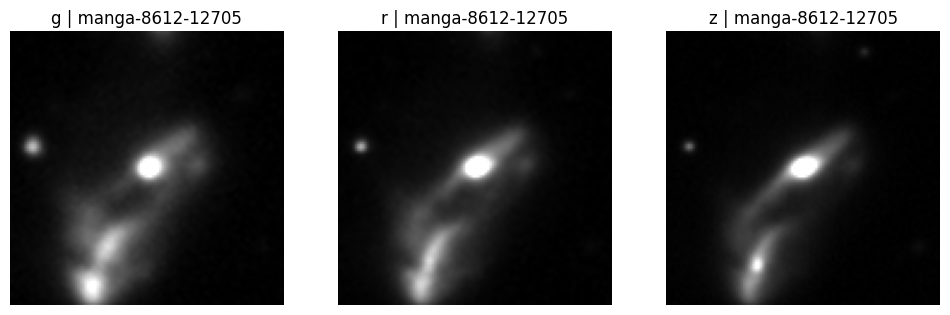

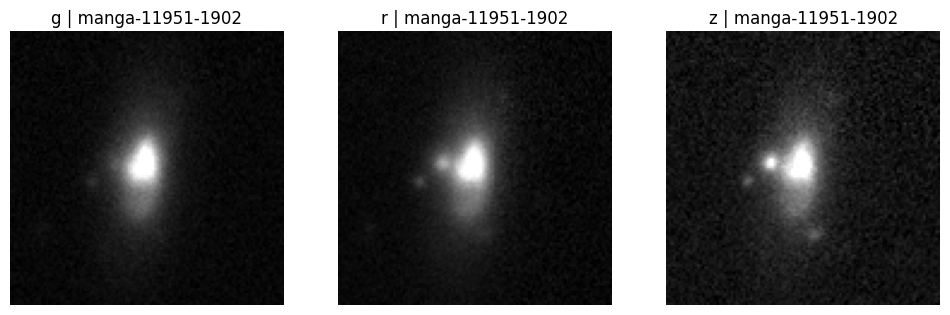

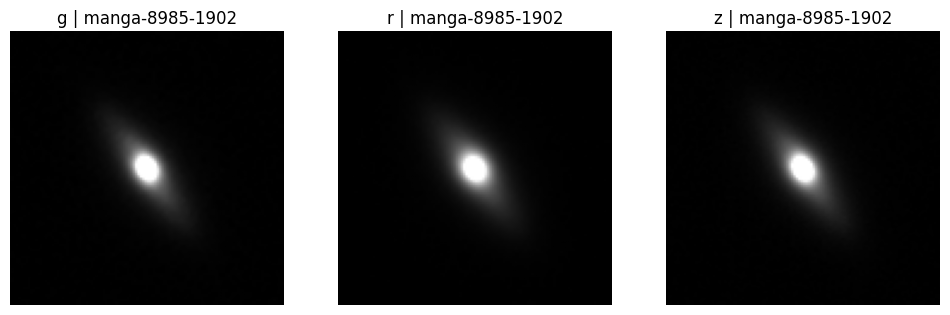

In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt, pandas as pd

def show_triplet(row, size=256, ncols=3):
    paths = [row["path_g"], row["path_r"], row["path_z"]]
    imgs = []
    for p in paths:
        ext = str(p).lower()
        if ext.endswith(".fits") or ext.endswith(".fz"):
            from astropy.io import fits
            with fits.open(p, memmap=False) as hdul:
                # toma primera HDU 2D
                for h in hdul:
                    if h.data is not None and getattr(h.data,"ndim",0)==2:
                        arr = h.data.astype(np.float32); break
        else:
            arr = cv2.imread(p, cv2.IMREAD_UNCHANGED)
            if arr.ndim==3: arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
            arr = arr.astype(np.float32)
        lo, hi = np.percentile(arr, [1, 99.5])
        arr = np.clip((arr-lo)/(hi-lo+1e-6), 0, 1)
        imgs.append(arr)

    plt.figure(figsize=(12,4))
    for i, (img, band) in enumerate(zip(imgs, ["g","r","z"]), 1):
        plt.subplot(1, ncols, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"{band} | {row['image_id']}")
        plt.axis("off")
    plt.show()

# Muestra 3 de train_grz
sample = train_grz.sample(min(3, len(train_grz)), random_state=0)
for _, row in sample.iterrows():
    show_triplet(row)


## Descarga de Galaxias sin barra

### Inputs, endpoints y funciones

In [ ]:
# Descarga adicional para galaxias sin barra (Bars ≤ 0.25)

PROJ_ROOT   = "/content/drive/MyDrive/Proyecto_Integrador"
DATA_DIR    = f"{PROJ_ROOT}/data"
MASTER_CSV  = f"{PROJ_ROOT}/data/dataset.csv"

LAYER = "ls-dr9"
PIX_SCALE = 0.262
CUTOUT_ARCMIN = 0.5
SIZE_PIX = int((CUTOUT_ARCMIN*60.0)/PIX_SCALE)
SIZE_PIX = max(64, min(SIZE_PIX, 2048))
BANDS = ["g","r","z"]

RETRIES = 2
TIMEOUT = 60
SLEEP   = 0.25
NWORK   = 8

os.makedirs(DATA_DIR, exist_ok=True)

df = pd.read_csv(MASTER_CSV)
df["Bars"] = pd.to_numeric(df["Bars"], errors="coerce")
df["image_id"] = df["name"].astype(str)
df = df.dropna(subset=["objra","objdec","Bars"])

# Filtramos galaxias sin barra
df_no_bar = df[df["Bars"] <= 0.25].copy()
print("Galaxias sin barra:", len(df_no_bar))

def cutout_urls(ra, dec, band):
    u1 = f"https://www.legacysurvey.org/viewer/fits-cutout?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    u2 = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    return [u1, u2]

def download_one(name, ra, dec, band):
    out_path = os.path.join(DATA_DIR, f"{name}_{band}.fits")
    if os.path.exists(out_path) and os.path.getsize(out_path) > 1000:
        return (name, band, True, "exists")
    for u in cutout_urls(ra, dec, band):
        for _ in range(RETRIES):
            try:
                r = requests.get(u, timeout=TIMEOUT)
                if r.status_code == 200 and r.content and len(r.content) > 1000:
                    with open(out_path, "wb") as f:
                        f.write(r.content)
                    return (name, band, True, "ok")
            except Exception:
                pass
            time.sleep(SLEEP)
    return (name, band, False, "fail")

jobs = []
with ThreadPoolExecutor(max_workers=NWORK) as ex:
    for _, row in df_no_bar.iterrows():
        for b in BANDS:
            jobs.append(ex.submit(download_one, row["image_id"], row["objra"], row["objdec"], b))

ok = fail = 0
for fut in as_completed(jobs):
    _, _, success, _ = fut.result()
    if success: ok += 1
    else: fail += 1

print(f"Descargas completadas → OK: {ok}, FAIL: {fail}")


Galaxias sin barra: 6783
Descargas completadas → OK: 20334, FAIL: 15


### Actualización de manifest y archivos

In [ ]:
import os, re, glob, pandas as pd
from astropy.io import fits

PROJ_ROOT    = "/content/drive/MyDrive/Proyecto_Integrador"
DATA_DIR     = f"{PROJ_ROOT}/data"
DATASETS_DIR = f"{PROJ_ROOT}/Deteccion/datasets"
MASTER_CSV   = f"{PROJ_ROOT}/data/dataset.csv"

BAND_RE = re.compile(r"_(g|r|z)(?=\.fits$)", re.IGNORECASE)

records = {}
for p in glob.glob(os.path.join(DATA_DIR, "*.fits")):
    base = os.path.basename(p).lower()
    m = BAND_RE.search(base)
    if not m: continue
    b = m.group(1)
    image_id = re.sub(BAND_RE, "", base)
    image_id = os.path.splitext(image_id)[0]
    rec = records.get(image_id, {"image_id":image_id, "path_g":None,"path_r":None,"path_z":None,
                                 "hdu_g":None,"hdu_r":None,"hdu_z":None,"format_hint":"per_band","raw_path":None})
    rec[f"path_{b}"] = p
    records[image_id] = rec

manifest = pd.DataFrame.from_dict(records, orient="index").reset_index(drop=True)
master = pd.read_csv(MASTER_CSV)
manifest = manifest[manifest["image_id"].isin(master["name"].astype(str))].reset_index(drop=True)
MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"
manifest.to_csv(MANIFEST_CSV, index=False)
print("Manifest actualizado:", MANIFEST_CSV, "| filas:", len(manifest))

# Recrear *_paths y *_grz
for split in ["train","val","test"]:
    base = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    merged = base.merge(manifest, on="image_id", how="left")
    merged.to_csv(f"{DATASETS_DIR}/{split}_paths.csv", index=False)
    m = (~merged["path_g"].isna()) & (~merged["path_r"].isna()) & (~merged["path_z"].isna())
    merged[m].to_csv(f"{DATASETS_DIR}/{split}_grz.csv", index=False)
    print(f"{split} → total {len(merged)} | GRZ {int(m.sum())}")


Manifest actualizado: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/manifest.csv | filas: 6778
train → total 7088 | GRZ 4744
val → total 1519 | GRZ 1017
test → total 1519 | GRZ 1017


In [ ]:
import pandas as pd
DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"

for split in ["train_grz","val_grz","test_grz"]:
    df = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    print(f"{split} ({len(df)} muestras)")
    print(df["label_bin"].value_counts(normalize=True).rename("ratio"), "\n")


train_grz (4744 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 

val_grz (1017 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 

test_grz (1017 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 



In [ ]:
import pandas as pd
DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"

train_p = pd.read_csv(f"{DATASETS_DIR}/train_paths.csv")
val_p   = pd.read_csv(f"{DATASETS_DIR}/val_paths.csv")
test_p  = pd.read_csv(f"{DATASETS_DIR}/test_paths.csv")

def keep_full_grz(df):
    m = (~df["path_g"].isna()) & (~df["path_r"].isna()) & (~df["path_z"].isna())
    return df[m].reset_index(drop=True), (~m).sum()

train_grz, miss_tr = keep_full_grz(train_p)
val_grz,   miss_va = keep_full_grz(val_p)
test_grz,  miss_te = keep_full_grz(test_p)

print("GRZ completos → train/val/test:", len(train_grz), len(val_grz), len(test_grz))
print("Incompletos → train/val/test:", miss_tr, miss_va, miss_te)

print("\nBalance (GRZ):")
for name, d in [("train_grz", train_grz), ("val_grz", val_grz), ("test_grz", test_grz)]:
    print(name)
    print(d["label_bin"].value_counts(normalize=True).rename("ratio").sort_index())

# Guardar (por si no existen o quieres refrescar)
train_grz.to_csv(f"{DATASETS_DIR}/train_grz.csv", index=False)
val_grz.to_csv(f"{DATASETS_DIR}/val_grz.csv", index=False)
test_grz.to_csv(f"{DATASETS_DIR}/test_grz.csv", index=False)


GRZ completos → train/val/test: 4744 1017 1017
Incompletos → train/val/test: 2344 502 502

Balance (GRZ):
train_grz
label_bin
0    1.0
Name: ratio, dtype: float64
val_grz
label_bin
0    1.0
Name: ratio, dtype: float64
test_grz
label_bin
0    1.0
Name: ratio, dtype: float64


## Comprobación de balanceo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

PROJ_ROOT    = "/content/drive/MyDrive/Proyecto_Integrador"
DATASETS_DIR = f"{PROJ_ROOT}/Deteccion/datasets"
DATA_DIR     = f"{PROJ_ROOT}/data"
MASTER_CSV   = f"{PROJ_ROOT}/data/dataset.csv"

THRESH_NEG = 0.25
THRESH_POS = 0.50
R_TRAIN, R_VAL, R_TEST = 0.70, 0.15, 0.15
SEED = 42

df = pd.read_csv(MASTER_CSV)
df["image_id"] = df["name"].astype(str)
df["Bars"] = pd.to_numeric(df["Bars"], errors="coerce")

def to_bin(x):
    if x <= THRESH_NEG: return 0
    if x >= THRESH_POS: return 1
    return -1

df["label_bin"] = df["Bars"].apply(to_bin)
df_clean = df[df["label_bin"].isin([0,1])].copy()

print("Total limpio:", len(df_clean))
print(df_clean["label_bin"].value_counts(normalize=True).rename("ratio"))

# --- Split estratificado ---
train_df, temp_df = train_test_split(df_clean, test_size=(1-R_TRAIN), random_state=SEED, stratify=df_clean["label_bin"])
val_df, test_df   = train_test_split(temp_df, test_size=(1 - (R_VAL/(R_VAL+R_TEST))), random_state=SEED, stratify=temp_df["label_bin"])

cols_out = ["image_id","label_bin","Bars","name","objra","objdec"]
for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    d[cols_out].to_csv(f"{DATASETS_DIR}/{name}.csv", index=False)
    print(f"{name}: {len(d)} muestras (0/1) →")
    print(d["label_bin"].value_counts(normalize=True).rename("ratio"), "\n")


Total limpio: 10126
label_bin
0    0.66986
1    0.33014
Name: ratio, dtype: float64
train: 7088 muestras (0/1) →
label_bin
0    0.669865
1    0.330135
Name: ratio, dtype: float64 

val: 1519 muestras (0/1) →
label_bin
0    0.670178
1    0.329822
Name: ratio, dtype: float64 

test: 1519 muestras (0/1) →
label_bin
0    0.669519
1    0.330481
Name: ratio, dtype: float64 



In [ ]:
import pandas as pd, os

DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"
MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"

man = pd.read_csv(MANIFEST_CSV)

def merge_paths(df, man):
    df2 = df.merge(man, how="left", on="image_id")
    ok_grz = ((~df2["path_g"].isna()) & (~df2["path_r"].isna()) & (~df2["path_z"].isna())).sum()
    print(f"{len(df2)} filas | con GRZ = {ok_grz}")
    return df2

for split in ["train","val","test"]:
    df = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    dfp = merge_paths(df, man)
    dfp.to_csv(f"{DATASETS_DIR}/{split}_paths.csv", index=False)

    # Crear versión sólo con GRZ completo
    m = (~dfp["path_g"].isna()) & (~dfp["path_r"].isna()) & (~dfp["path_z"].isna())
    dfp[m].to_csv(f"{DATASETS_DIR}/{split}_grz.csv", index=False)


7088 filas | con GRZ = 4744
1519 filas | con GRZ = 1017
1519 filas | con GRZ = 1017


In [ ]:
for split in ["train_grz","val_grz","test_grz"]:
    df = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    print(f"{split} ({len(df)} muestras)")
    print(df["label_bin"].value_counts(normalize=True).rename("ratio"), "\n")


train_grz (4744 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 

val_grz (1017 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 

test_grz (1017 muestras)
label_bin
0    1.0
Name: ratio, dtype: float64 



In [ ]:
import pandas as pd, os, re, requests, time, glob
from concurrent.futures import ThreadPoolExecutor, as_completed

PROJ_ROOT    = "/content/drive/MyDrive/Proyecto_Integrador"
DATA_DIR     = f"{PROJ_ROOT}/data"
DATASETS_DIR = f"{PROJ_ROOT}/Deteccion/datasets"
MASTER_CSV   = f"{PROJ_ROOT}/data/dataset.csv"
MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"

LAYER = "ls-dr9"
PIX_SCALE = 0.262
CUTOUT_ARCMIN = 0.5
SIZE_PIX = int((CUTOUT_ARCMIN*60.0)/PIX_SCALE)
SIZE_PIX = max(64, min(SIZE_PIX, 2048))
BANDS = ["g","r","z"]
RETRIES = 2
TIMEOUT = 60
SLEEP = 0.25
NWORK = 8

# --- 1) Leer manifest y master ---
manifest = pd.read_csv(MANIFEST_CSV)
master = pd.read_csv(MASTER_CSV)
master["image_id"] = master["name"].astype(str)
master["Bars"] = pd.to_numeric(master["Bars"], errors="coerce")
df_bar = master[master["Bars"] >= 0.5].copy()

# --- 2) Encontrar cuáles faltan ---
need = []
for _, row in df_bar.iterrows():
    img_id = str(row["image_id"])
    subset = manifest[manifest["image_id"] == img_id]
    if subset.empty:
        for b in BANDS: need.append((img_id, row["objra"], row["objdec"], b))
    else:
        for b in BANDS:
            if pd.isna(subset.iloc[0].get(f"path_{b}")):
                need.append((img_id, row["objra"], row["objdec"], b))

print(f"Galaxias con barra a completar: {len(set([n[0] for n in need]))}")
print("Total descargas necesarias:", len(need))

# --- 3) Función de descarga ---
def cutout_urls(ra, dec, band):
    u1 = f"https://www.legacysurvey.org/viewer/fits-cutout?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    u2 = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={ra}&dec={dec}&layer={LAYER}&pixscale={PIX_SCALE}&size={SIZE_PIX}&bands={band}"
    return [u1, u2]

def dl_one(img_id, ra, dec, band):
    out_path = os.path.join(DATA_DIR, f"{img_id}_{band}.fits")
    if os.path.exists(out_path) and os.path.getsize(out_path) > 1000:
        return (img_id, band, True, "exists")
    for u in cutout_urls(ra, dec, band):
        for _ in range(RETRIES):
            try:
                r = requests.get(u, timeout=TIMEOUT)
                if r.status_code==200 and r.content and len(r.content)>1000:
                    with open(out_path, "wb") as f:
                        f.write(r.content)
                    return (img_id, band, True, "ok")
            except Exception as e:
                last = str(e)
            time.sleep(SLEEP)
    return (img_id, band, False, last if 'last' in locals() else "fail")

# --- 4) Descargar en paralelo ---
jobs=[]
with ThreadPoolExecutor(max_workers=NWORK) as ex:
    for (img_id, ra, dec, band) in need:
        jobs.append(ex.submit(dl_one, img_id, ra, dec, band))

ok=fail=0
for fut in as_completed(jobs):
    _,_,s,_=fut.result()
    ok += int(s)
    fail += int(not s)

print("Descargas completadas: OK =", ok, "| FAIL =", fail)


Galaxias con barra a completar: 3343
Total descargas necesarias: 10029
Descargas completadas: OK = 10026 | FAIL = 3


In [ ]:
import os, re, glob, pandas as pd
from astropy.io import fits

PROJ_ROOT    = "/content/drive/MyDrive/Proyecto_Integrador"
DATA_DIR     = f"{PROJ_ROOT}/data"
DATASETS_DIR = f"{PROJ_ROOT}/Deteccion/datasets"
MASTER_CSV   = f"{PROJ_ROOT}/data/dataset.csv"

BAND_RE = re.compile(r"_(g|r|z)(?=\.fits$)", re.IGNORECASE)

records = {}
files = glob.glob(os.path.join(DATA_DIR, "*.fits"))
for p in files:
    base = os.path.basename(p).lower()
    m = BAND_RE.search(base)
    if not m:
        continue
    b = m.group(1)
    image_id = re.sub(BAND_RE, "", base)
    image_id = os.path.splitext(image_id)[0]
    rec = records.get(image_id, {
        "image_id":image_id, "path_g":None,"path_r":None,"path_z":None,
        "hdu_g":None,"hdu_r":None,"hdu_z":None,"format_hint":"per_band","raw_path":None
    })
    rec[f"path_{b}"] = os.path.join(DATA_DIR, os.path.basename(p))
    records[image_id] = rec

manifest = pd.DataFrame.from_dict(records, orient="index").reset_index(drop=True)

# Mantener sólo ids presentes en master (seguridad)
master = pd.read_csv(MASTER_CSV)
manifest = manifest[manifest["image_id"].isin(master["name"].astype(str))].reset_index(drop=True)

MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"
manifest.to_csv(MANIFEST_CSV, index=False)
print("Manifest actualizado:", MANIFEST_CSV, "| filas:", len(manifest))


Manifest actualizado: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/manifest.csv | filas: 10120


In [ ]:
import pandas as pd, os

DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"
MANIFEST_CSV = f"{DATASETS_DIR}/manifest.csv"

man = pd.read_csv(MANIFEST_CSV)

def merge_paths(df, man):
    df2 = df.merge(man, how="left", on="image_id")
    ok_grz = ((~df2["path_g"].isna()) & (~df2["path_r"].isna()) & (~df2["path_z"].isna())).sum()
    print(f"{len(df2)} filas | con GRZ = {ok_grz}")
    return df2

for split in ["train","val","test"]:
    base = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    merged = merge_paths(base, man)
    merged.to_csv(f"{DATASETS_DIR}/{split}_paths.csv", index=False)

    m = (~merged["path_g"].isna()) & (~merged["path_r"].isna()) & (~merged["path_z"].isna())
    merged[m].to_csv(f"{DATASETS_DIR}/{split}_grz.csv", index=False)
    print(f"{split} → GRZ guardado:", f"{DATASETS_DIR}/{split}_grz.csv")


7088 filas | con GRZ = 7083
train → GRZ guardado: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/train_grz.csv
1519 filas | con GRZ = 1518
val → GRZ guardado: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/val_grz.csv
1519 filas | con GRZ = 1519
test → GRZ guardado: /content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets/test_grz.csv


In [ ]:
import pandas as pd

DATASETS_DIR = "/content/drive/MyDrive/Proyecto_Integrador/Deteccion/datasets"
for split in ["train_grz","val_grz","test_grz"]:
    df = pd.read_csv(f"{DATASETS_DIR}/{split}.csv")
    print(f"{split} ({len(df)} muestras)")
    print(df["label_bin"].value_counts(normalize=True).rename("ratio").sort_index())
    print("-"*40)


train_grz (7083 muestras)
label_bin
0    0.669773
1    0.330227
Name: ratio, dtype: float64
----------------------------------------
val_grz (1518 muestras)
label_bin
0    0.66996
1    0.33004
Name: ratio, dtype: float64
----------------------------------------
test_grz (1519 muestras)
label_bin
0    0.669519
1    0.330481
Name: ratio, dtype: float64
----------------------------------------
